## Implementation of LSTM-RNN with PyTorch

In [14]:
# import Yahoo Finance module to obtain dataset

import yfinance as yf

In [16]:
# import basic numerical and graphical tools

import time
import itertools
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
# import machine learning frameworks

from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor

In [20]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


### Proposed data acquisition

In [35]:
# test ticker: magnificent-7

tickers = ['F', 'ALV', 'FDX', 'DNZOY', 'ASEKY', 'JCI', 'GM', 'TM', 'CL=F', 'X',  # Company tickers
           'EURUSD=X', 'CHFUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'CADUSD=X', 'INRUSD=X', 'RUBUSD=X', 'TRYUSD=X',  # Currencies
           '^IRX', 'JPM', 'BAC', 'C', 'WFC',  # Financial companies and IRX
           '^IXIC', '^GSPC', '^DJI'  # NASDAQ, S&P 500, Dow Jones
          ]
raw_data = yf.download(tickers, start='2019-01-01')
data = pd.DataFrame(data=raw_data['Adj Close']).reset_index()
data['Date'] = pd.to_datetime(data['Date']).dt.date
data

[*********************100%***********************]  26 of 26 completed


Ticker,Date,ALV,ASEKY,BAC,C,CADUSD=X,CHFUSD=X,CL=F,DNZOY,EURUSD=X,...,JPYUSD=X,RUBUSD=X,TM,TRYUSD=X,WFC,X,^DJI,^GSPC,^IRX,^IXIC
0,2019-01-01,NaN,NaN,NaN,NaN,0.746586,1.016766,NaN,NaN,1.149306,...,0.009122,0.014456,NaN,0.189753,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,61.183887,11.296667,21.671215,43.392143,0.733923,1.018330,46.540001,11.280,1.146171,...,0.009118,0.014515,116.279999,0.189082,39.733086,17.757433,23346.240234,2510.030029,2.365,6665.939941
2,2019-01-03,59.063618,11.606667,21.323923,42.605846,0.733611,1.011429,47.090000,11.155,1.131811,...,0.009307,0.014487,114.650002,0.181314,39.419888,17.728655,22686.220703,2447.889893,2.355,6463.500000
3,2019-01-04,61.209961,11.606667,22.209522,44.689121,0.741906,1.013069,47.959999,11.420,1.139108,...,0.009276,0.014522,119.730003,0.182742,40.588005,19.513033,23433.160156,2531.939941,2.358,6738.859863
4,2019-01-07,62.035473,12.273333,22.192158,45.078213,0.747982,1.014446,48.520000,11.550,1.141044,...,0.009215,0.014800,121.279999,0.187723,40.325607,19.618561,23531.349609,2549.689941,2.353,6823.470215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,2024-10-23,96.500000,10.650000,42.340000,63.099998,0.723788,1.155361,70.769997,13.840,1.079727,...,0.006616,0.010445,171.330002,0.029194,64.559998,39.509998,42514.949219,5797.419922,4.505,18276.650391
1517,2024-10-24,95.040001,10.650000,42.650002,63.000000,0.722716,1.153749,70.190002,13.810,1.078051,...,0.006546,0.010422,170.429993,0.029181,65.430000,39.500000,42374.359375,5809.859863,4.487,18415.490234
1518,2024-10-25,94.739998,10.650000,41.889999,61.759998,0.721850,1.154908,71.779999,13.800,1.082415,...,0.006588,0.010390,172.000000,0.029165,64.529999,38.790001,42114.398438,5808.120117,4.510,18518.609375
1519,2024-10-28,97.080002,10.650000,42.619999,64.160004,0.719652,1.151464,67.379997,13.980,1.079657,...,0.006538,0.010283,176.630005,0.029169,65.610001,38.430000,42387.570312,5823.520020,4.482,18567.189453


In [394]:
df = data[['Date', 'DNZOY']].dropna()
df

Ticker,Date,DNZOY
1,2019-01-02,11.280
2,2019-01-03,11.155
3,2019-01-04,11.420
4,2019-01-07,11.550
5,2019-01-08,11.625
...,...,...
1516,2024-10-23,13.840
1517,2024-10-24,13.810
1518,2024-10-25,13.800
1519,2024-10-28,13.980


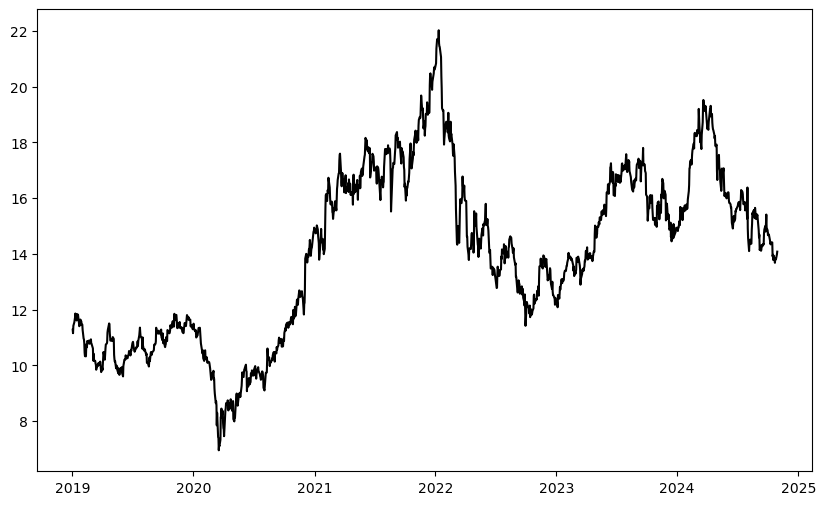

In [396]:
date = df['Date']
price = df['DNZOY']

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date, price, color='k')
plt.show()

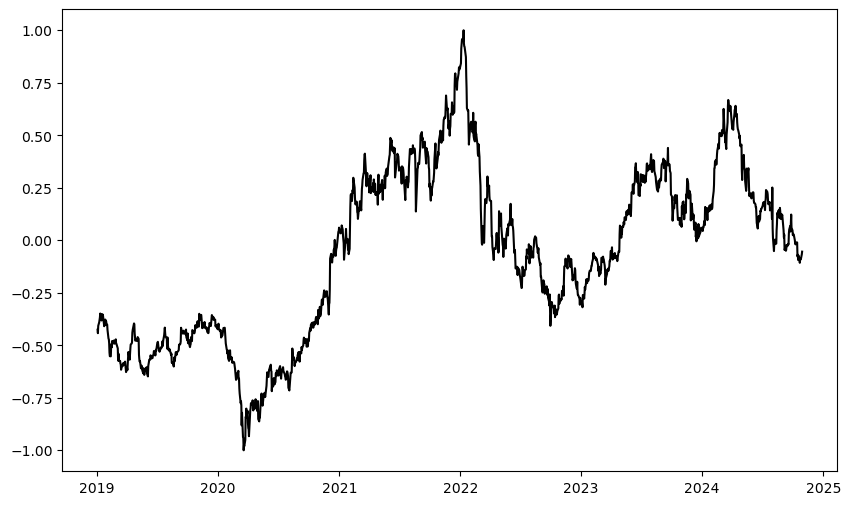

In [398]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = scaler.fit_transform(price.values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date, price, color='k')
plt.show()

In [400]:
def gen_inputs(price_data, window_size, test_size=0.2):
    price_data = price_data
    inputs = []
    
    # create all possible sequences of length look_back
    for idx in range(len(price_data) - window_size): 
        inputs.append(price_data[idx:idx + window_size])
    inputs = np.array(inputs)
    
    test_size = int(np.round(test_size * inputs.shape[0]))
    train_size = inputs.shape[0] - test_size
    
    x_train = inputs[:train_size, :-1]
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    y_train = inputs[:train_size, -1]
    y_train = y_train.reshape(y_train.shape[0], 1)
    
    x_test = inputs[train_size:, :-1]
    x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], 1)
    y_test = inputs[train_size:, -1]
    y_test = y_test.reshape(y_test.shape[0], 1)
    
    return x_train, y_train, x_test, y_test

In [402]:
window_size = 20

x_train, y_train, x_test, y_test = gen_inputs(price, window_size=window_size, test_size=0.1)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (1302, 19, 1)
y_train.shape =  (1302, 1)
x_test.shape =  (145, 19, 1)
y_test.shape =  (145, 1)


In [404]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [406]:
x_train.size(), y_train.size()

(torch.Size([1302, 19, 1]), torch.Size([1302, 1]))

### Build LSTM Models

In [409]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # module hyperparameters
        
        # input_dim: number of features of the input data x
        # hidden_dim: number of features in the hidden state h
        # num_layers: number of stacked LSTM layers
        # output_dim: number of features of the output data of the module
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # batch_first=True: input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # by torch.Tensor.detach, the truncated backpropagation through time (BPTT) is applied
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # index hidden state of last time step: choose only the last time step of the hidden states
        # ex) out.size() --> 100, 32, 100 so that out[:, -1, :] --> 100, 100
        out = self.fc(out[:, -1, :]) 

        return out

### Model structure by parameters

In [412]:
model_ex = LSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)

print(model_ex)
print(len(list(model_ex.parameters())))
for i in range(len(list(model_ex.parameters()))):
    print(list(model_ex.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Train the LSTM model

In [415]:
num_epochs = 500
loss_hist = np.zeros((3, num_epochs))

# number of steps to unroll
seq_dim = window_size - 1  

# initialize the model
models = {}
for i in [1, 2, 3]:
    models[i] = LSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=i)

# loss function to be employed
loss_fn = torch.nn.MSELoss()

# optimizer to be employed
optimizers = {}
for i in [1, 2, 3]:
    optimizers[i] = torch.optim.Adam(models[i].parameters(), lr=0.01)

y_train_preds = {}
for t in range(num_epochs):
    # initialize hidden state: don't need this if the LSTM is to be stateful
    #model.hidden = model.init_hidden()
    
    # train the model by the forward propagation
    for i in [1, 2, 3]:
        y_train_preds[i] = models[i](x_train)

        # calculate loss
        loss = loss_fn(y_train_preds[i], y_train)
        loss_hist[i - 1, t] = loss.item()
    
        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
    
        # reset the previous gradient values in the optimizer not to make accumulation
        optimizers[i].zero_grad()

        # backpropagation
        loss.backward()

        # update parameters
        optimizers[i].step()

Epoch  10 MSE:  0.026388388127088547
Epoch  10 MSE:  0.0495113842189312
Epoch  10 MSE:  0.023065367713570595
Epoch  20 MSE:  0.005990857724100351
Epoch  20 MSE:  0.016613058745861053
Epoch  20 MSE:  0.015567143447697163
Epoch  30 MSE:  0.00424968171864748
Epoch  30 MSE:  0.010310620069503784
Epoch  30 MSE:  0.006240005139261484
Epoch  40 MSE:  0.0026898724026978016
Epoch  40 MSE:  0.006200416013598442
Epoch  40 MSE:  0.004529728554189205
Epoch  50 MSE:  0.002438149182125926
Epoch  50 MSE:  0.005135821644216776
Epoch  50 MSE:  0.0036873221397399902
Epoch  60 MSE:  0.002174422377720475
Epoch  60 MSE:  0.004487642087042332
Epoch  60 MSE:  0.003128879005089402
Epoch  70 MSE:  0.00206478638574481
Epoch  70 MSE:  0.003765644272789359
Epoch  70 MSE:  0.0027052559889853
Epoch  80 MSE:  0.0019768460188061
Epoch  80 MSE:  0.0033702761866152287
Epoch  80 MSE:  0.002473916858434677
Epoch  90 MSE:  0.0019107047701254487
Epoch  90 MSE:  0.0030813440680503845
Epoch  90 MSE:  0.002289739204570651
Epoc

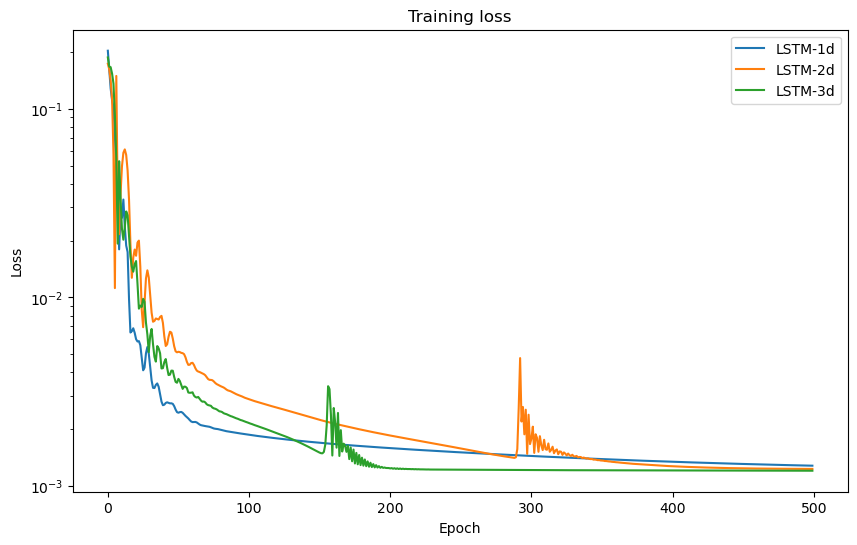

In [417]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in [1, 2, 3]:
    ax.plot(loss_hist[i - 1, :], label="LSTM-%dd" % i)

plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [419]:
# make a prediction by running the algorithm
y_test_preds = {}

for i in [1, 2, 3]:
    y_test_preds[i] = models[i](x_test)
    
    # apply the inverse scaler
    y_train_preds[i] = scaler.inverse_transform(y_train_preds[i].detach().numpy())
    y_test_preds[i] = scaler.inverse_transform(y_test_preds[i].detach().numpy())

#y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [421]:
# RMS error
rms_train, rms_test = [], []

for i in [1, 2, 3]:
    rms_train.append(np.sqrt(mean_squared_error(y_train[:, 0], y_train_preds[i][:, 0])))
    rms_test.append(np.sqrt(mean_squared_error(y_test[:, 0], y_test_preds[i][:, 0])))

print('Train Score:', rms_train)
print('Test Score:', rms_test)

Train Score: [14.180932, 14.181364, 14.181426]
Test Score: [0.28129074, 0.28182572, 0.28130025]


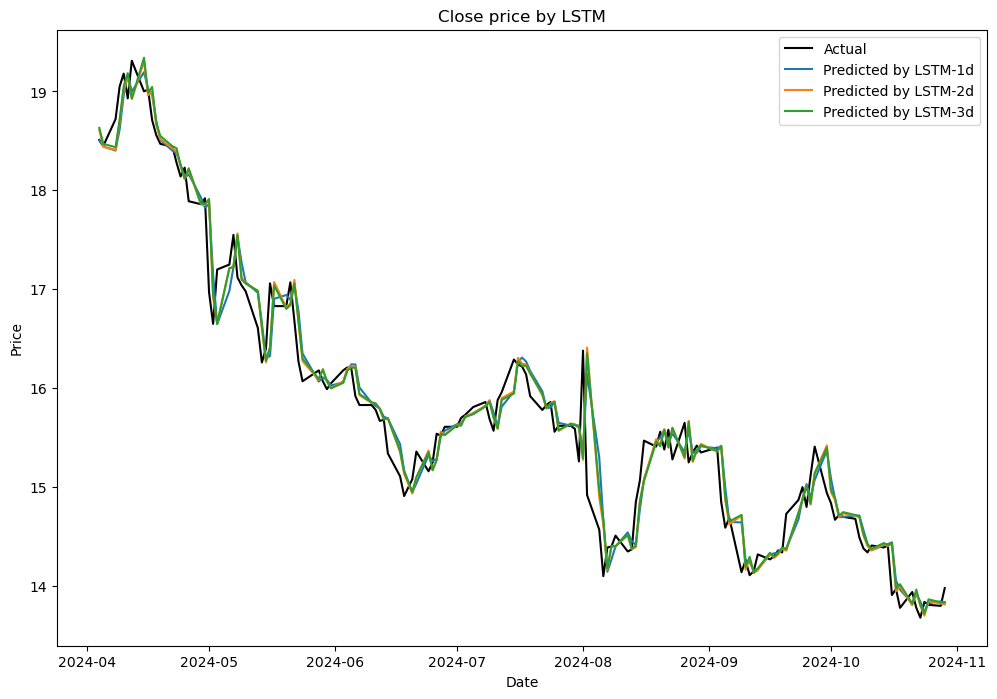

In [423]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(date[len(df) - len(y_test):], y_test, 
        color='k',
        label='Actual')
for i in [1, 2, 3]:
    ax.plot(date[len(df) - len(y_test):], y_test_preds[i],
            label ='Predicted by LSTM-%dd' % i)

plt.title('Close price by LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Price up/down prediction and accuracy

In [431]:
diff = pd.DataFrame(index=date[-len(y_test):], data={'real': y_test.reshape(-1)})
#diff['real_diff'] = diff['real'].rolling(2).apply(lambda x: x[1] - x[0])

for i in [1, 2, 3]:
    diff['pred%d' % i] = y_test_preds[i].reshape(-1)
    #diff['pred_diff%d' % i] = diff['pred%d' % i] - diff['real']
    diff['pred_diff%d' % i] = diff['pred%d' % i].rolling(2).apply(lambda x: x[1] - x[0])

diff = diff.dropna()
diff

/var/folders/fr/qyxdtyxj3sg8fgvfqttmm3980000gn/T/ipykernel_81881/401733304.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff['real_diff'] = diff['real'].rolling(2).apply(lambda x: x[1] - x[0])
/var/folders/fr/qyxdtyxj3sg8fgvfqttmm3980000gn/T/ipykernel_81881/401733304.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff['pred_diff%d' % i] = diff['pred%d' % i].rolling(2).apply(lambda x: x[1] - x[0])
/var/folders/fr/qyxdtyxj3sg8fgvfqttmm3980000gn/T/ipykernel_81881/401733304.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

,real,real_diff,pred1,pred_diff1,pred2,pred_diff2,pred3,pred_diff3
Date,,,,,,,,
2024-04-05,18.450001,-0.059999,18.442671,-0.060631,18.440277,-0.171438,18.469664,-0.162001
2024-04-08,18.719999,0.269999,18.401840,-0.040831,18.408688,-0.031590,18.436434,-0.033230
2024-04-09,19.049999,0.330000,18.616070,0.214230,18.689978,0.281290,18.714376,0.277943
2024-04-10,19.180000,0.130001,18.961008,0.344938,19.014933,0.324955,19.052984,0.338608
2024-04-11,18.930000,-0.250000,19.166084,0.205076,19.159544,0.144611,19.184975,0.131990
...,...,...,...,...,...,...,...,...
2024-10-23,13.680000,-0.099999,13.843558,-0.072112,13.798933,-0.144436,13.810041,-0.154297
2024-10-24,13.840000,0.160000,13.736406,-0.107152,13.701147,-0.097786,13.721098,-0.088943
2024-10-25,13.810000,-0.030000,13.826786,0.090380,13.848531,0.147384,13.865841,0.144743


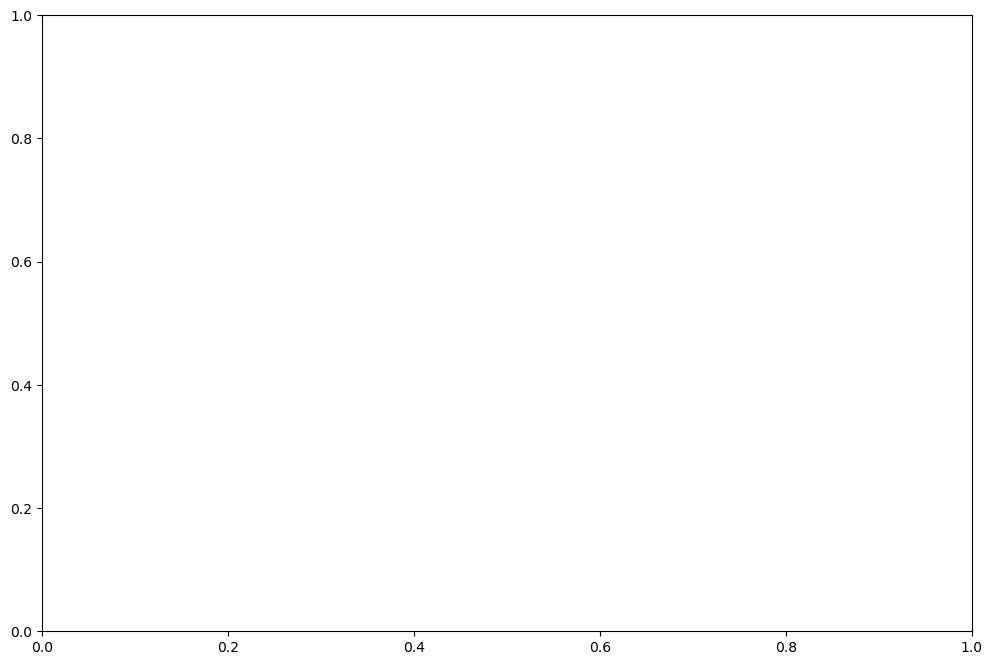

In [433]:
fig, ax = plt.subplots(figsize=(12, 8))



In [435]:
accuracy = np.zeros(3)
for i in [1, 2, 3]:
    accuracy[i - 1] = np.sum(diff['real_diff'].apply(np.sign) == diff['pred_diff%i' % i].apply(np.sign)) / len(diff['real_diff'])

accuracy

array([0.47916667, 0.45833333, 0.44444444])